In [1]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[1]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

In [2]:
def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp, ignore_lnkadd_err = False):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    if ignore_lnkadd_err:
        lnKKp1_err = lnkobs_err

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / 4184) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err, KKp1, KKp1_err

In [3]:
df = pd.read_csv('../4U_2stateMelt/kinetic_params_per_nt/4U_kinetic_params_25C.csv')
df_A18 = pd.read_csv('../4U_2stateMelt/kinetic_params_per_nt/4U_A18_kinetic_params_25C.csv')

# concat
df = pd.concat([df, df_A18], ignore_index=True)
df['site_num'] = df['site'].str.split('_').str[0].astype(int)
df['ln_kobs_err'] = df['ln_kobs_err'].apply(lambda x: 0 if x > 50 else x)
df['dG'] = df.apply(lambda x: calc_dG(x['ln_kobs'], x['ln_kobs_err'], x['ln_kadd'], x['ln_kadd_err'], 25)[0], axis=1)
df['dG_err'] = df.apply(lambda x: calc_dG(x['ln_kobs'], x['ln_kobs_err'], x['ln_kadd'], x['ln_kadd_err'], 25)[1], axis=1)
df.to_csv('fourU_dG.csv', index=False)

In [4]:
### Calculate ddG between 4U_wt and 4U_a8c

wt  = df[df['construct'] == '4U_wt'].copy()
a8c = df[df['construct'] == '4U_a8c'].copy()

# Merge on both site and site_num to keep a single site_num column
merged_df = pd.merge(
    wt,
    a8c,
    on=['site_num'],
    suffixes=('_wt', '_a8c')
)

# Keep only the relevant columns
merged_df = merged_df[['site_num', 'dG_wt', 'dG_err_wt', 'dG_a8c', 'dG_err_a8c']]

# Compute ddG and its propagated error
merged_df['ddG'] = merged_df['dG_a8c'] - merged_df['dG_wt']
merged_df['ddG_err'] = np.sqrt(merged_df['dG_err_wt']**2 + merged_df['dG_err_a8c']**2)

# Sort by site number for plotting
merged_df = merged_df.sort_values(by='site_num')

# Save to CSV
merged_df.to_csv('fourU_ddG.csv', index=False)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


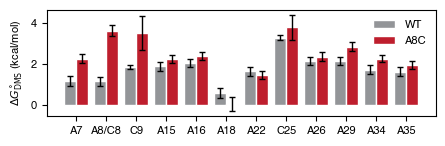

In [5]:
# Set color palette manually
palette = ['#939598', '#BE1E2D']
label_order = df['construct'].unique()

# Sort sites numerically
sorted_sites = sorted(df['site_num'].unique())
x = np.arange(len(sorted_sites))

fig, ax = plt.subplots(figsize=(4.5, 1.5))
bar_width = 0.4

for i, label in enumerate(label_order):

    df_subset = df[df['construct'] == label].copy()

    # Reindex using site_num to ensure ordering + handle missing sites
    df_subset = df_subset.set_index('site_num').reindex(sorted_sites)

    offset = (i - 0.5) * bar_width

    ax.bar(
        x + offset,
        df_subset['dG'],
        yerr=df_subset['dG_err'],
        width=bar_width,
        label=label,
        color=palette[i],
        edgecolor='white',
        capsize=2,
        error_kw=dict(lw=1, capthick=1)  # <-- adjust these
    )

# Format plot
ax.set_xticks(x)
ax.set_xticklabels(['A7', 'A8/C8', 'C9', 'A15', 'A16', 'A18', 'A22', 'C25', 'A26', 'A29', 'A34', 'A35'])
ax.set_ylabel(r'$\Delta G^{\circ}_{\mathrm{DMS}}$ (kcal/mol)')

# change legend entry text to WT and A8C
handles, labels = ax.get_legend_handles_labels()
labels = ['WT', 'A8C']
ax.legend(handles, labels, frameon=False)

plt.tight_layout()
plt.savefig('fourU_dG_barplot.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


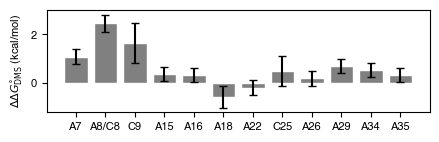

In [6]:


# ---- Plot ----
fig, ax = plt.subplots(figsize=(4.5, 1.5))

x = np.arange(len(merged_df))

ax.bar(
    x,
    merged_df['ddG'],
    yerr=merged_df['ddG_err'],
    color='gray',
    edgecolor='white',
    capsize=3
)

# If you have a label column (e.g. site_nt_wt), you can use it here.
# For now this just uses site numbers.
ax.set_xticks(x)
ax.set_xticklabels(['A7', 'A8/C8', 'C9', 'A15', 'A16', 'A18', 'A22', 'C25', 'A26', 'A29', 'A34', 'A35'])

ax.set_xlabel('')
ax.set_ylabel(r'$\Delta\Delta G^{\circ}_{\mathrm{DMS}}$ (kcal/mol)')

plt.tight_layout()
plt.savefig('fourU_calc_ddG.pdf')